In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={"font.size":9,"axes.titlesize":15,"axes.labelsize":9,
            "axes.titlepad":11, "axes.labelpad":9, "legend.fontsize":7,
            "legend.title_fontsize":7, 'axes.grid' : False})
import numpy as np
import pandas as pd
import os
import sys
import cv2
from tqdm.auto import tqdm 
import shutil
from pathlib import Path

In [2]:
base_dir = os.path.join('..', '..')
dataset = 'Dataset'
dataset_dir = os.path.join(base_dir, dataset)
Intermediates_dir = os.path.join('..', 'Intermediates')
Charts_Images_dir = os.path.join(Intermediates_dir, 'Charts_Images')
csv_txt_json_data = os.path.join(Intermediates_dir, 'csv_txt_json_data')

In [21]:
from utils_DP import draw_bbox, plot_multi_imgs

In [4]:
df_train = pd.read_csv(os.path.join(csv_txt_json_data, "dataset_after_processing.csv"), index_col= 0)
df_cluster = pd.read_csv(os.path.join(csv_txt_json_data, "K_mean_cluster_diseases.csv"), index_col= 0)

In [5]:
df_finding_train = df_train[df_train.class_id != 14]
df_non_finding_train = df_train[df_train.class_id == 14]

In [6]:
df_finding_train["cluster"] = df_finding_train.class_name.map(lambda x:  df_cluster[df_cluster["class_name"] == x]["label"].values[0])

<ipython-input-6-960ba5cf35ef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_finding_train["cluster"] = df_finding_train.class_name.map(lambda x:  df_cluster[df_cluster["class_name"] == x]["label"].values[0])


In [7]:
x = df_finding_train[["class_name", "class_id"]].groupby(by = ["class_name", "class_id"]).count().reset_index()
dct_class_ids = {}
for i in x.to_numpy():
  dct_class_ids[i[0]] = int(i[1])
dct_class_ids["No finding"] = 14



In [8]:
def GetKey(val):
   for key, value in dct_class_ids.items():
      if val == value:
        
        return key
      continue

In [9]:
label2color = [[59, 238, 119], [222, 21, 229], [94, 49, 164], [206, 221, 133], [117, 75, 3],
                 [210, 224, 119], [211, 176, 166], [63, 7, 197], [102, 65, 77], [194, 134, 175],
                 [209, 219, 50], [255, 44, 47], [89, 125, 149], [110, 27, 100]]

### 1. Split dataset accroding to cluster

In [10]:
df_finding_train_c_2 = df_finding_train[df_finding_train.cluster == 2]
df_finding_train_c_1 = df_finding_train[df_finding_train.cluster == 1]
df_finding_train_c_0 = df_finding_train[df_finding_train.cluster == 0]

In [11]:
df_finding_train_c_2.shape[0], df_finding_train_c_1.shape[0], df_finding_train_c_0.shape[0]

(1226, 14671, 20199)

### 1.1 Cluster 2

In [12]:
imgs_path_2 = df_finding_train_c_2.image_path.unique()

In [13]:
imgs_path_2[:5]

array(['..\\..\\Dataset\\train\\train\\0c7a38f293d5f5e4846aa4ca6db4daf1.jpg',
       '..\\..\\Dataset\\train\\train\\0a14aeaf02d42990d8bb5d55270b7274.jpg',
       '..\\..\\Dataset\\train\\train\\bdd0bebed953f69413213d387c9717e7.jpg',
       '..\\..\\Dataset\\train\\train\\6e4391555899c8474c4d32f42b2ba21b.jpg',
       '..\\..\\Dataset\\train\\train\\e3c5ff1eb0d55039f3bbc3c4875543c3.jpg'],
      dtype=object)

In [14]:
df_finding_train_c_2.class_name.unique()

array(['ILD', 'Pneumothorax'], dtype=object)

  0%|          | 0/3 [00:00<?, ?it/s]

6e4391555899c8474c4d32f42b2ba21b
boxes_label(id): 12
e3c5ff1eb0d55039f3bbc3c4875543c3
boxes_label(id): [12 12 12 12 12 12]
de20b8c80c04bd2dbe0782fb21738588
boxes_label(id): [5 5 5 5 5 5]


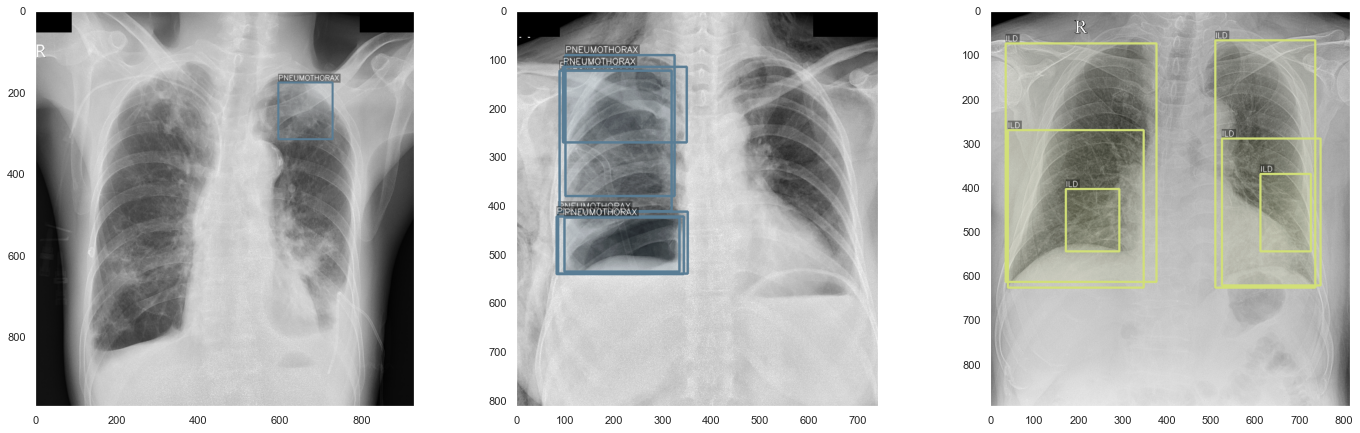

In [25]:
thickness =  3
viz_images_2 = []
for img_path in tqdm(imgs_path_2[3:6], total =len(imgs_path_2[3:6])):
  img_array = cv2.imread(img_path)
  img_copy = img_array.copy()
  img_id = Path(img_path).stem
  print(img_id)
  boxes_label = df_finding_train_c_2.loc[df_finding_train_c_2["image_id"] == img_id,["class_id"]].values.squeeze()
  boxes_location = df_finding_train_c_2.loc[df_finding_train_c_2["image_id"] == img_id,["x_min", "y_min", "x_max", "y_max"]].values  
  print(f"boxes_label(id): {boxes_label}")
  
  if len(boxes_location) == 1:
    color = label2color[boxes_label]
    img_copy = draw_bbox(img_copy, 
                    list(np.int_(boxes_location.squeeze())), 
                    GetKey(boxes_label), 
                    color, 
                    thickness = thickness)
  else:
    for label_id, box in zip(boxes_label, boxes_location):
      color = label2color[label_id]
      img_copy = draw_bbox(img_copy, 
                      list(np.int_(box)), 
                      GetKey(label_id), 
                      color, 
                      thickness = thickness)
  viz_images_2.append(img_copy)
plot_multi_imgs(imgs= viz_images_2, size = 8, cols = 3)

+ Comment: See the figure 3 with id: de20b8c80c04bd2dbe0782fb21738588 have multi label of ILD --> let's explore the reason why 

In [26]:
imgs_path_2[5]

'..\\..\\Dataset\\train\\train\\de20b8c80c04bd2dbe0782fb21738588.jpg'

In [28]:
_ = df_finding_train[df_finding_train.image_path == imgs_path_2[5]]
_ = _[["image_id", "class_name", "rad_id"]]
_ = _[_.class_name == "ILD"]
_

image_id class_name rad_id
407    de20b8c80c04bd2dbe0782fb21738588        ILD    R15
5881   de20b8c80c04bd2dbe0782fb21738588        ILD    R14
11156  de20b8c80c04bd2dbe0782fb21738588        ILD    R15
43432  de20b8c80c04bd2dbe0782fb21738588        ILD    R14
44501  de20b8c80c04bd2dbe0782fb21738588        ILD    R11
45045  de20b8c80c04bd2dbe0782fb21738588        ILD    R11

radiologist's id = R15
radiologist's id = R14
radiologist's id = R11


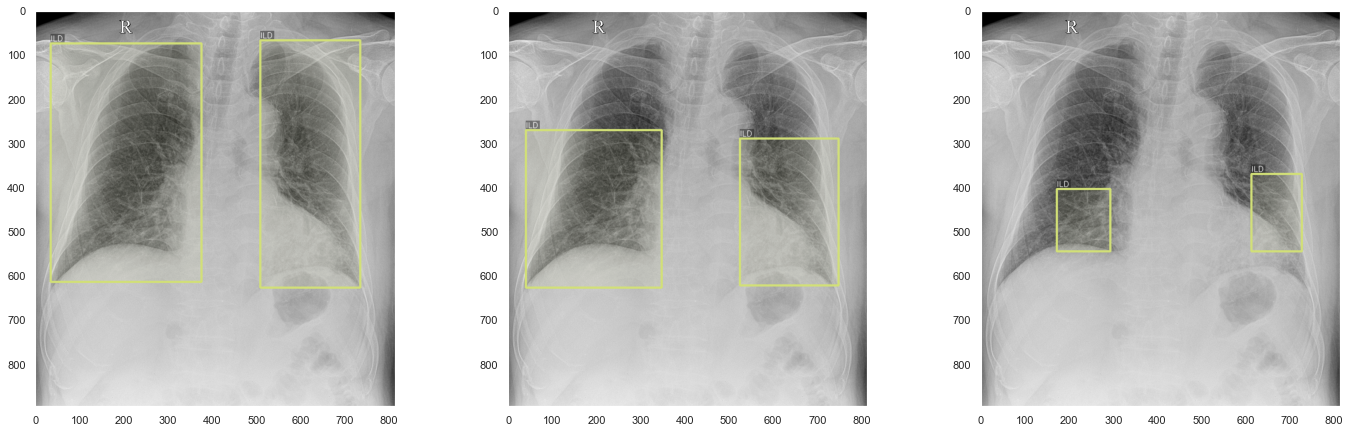

In [31]:
viz_images_2 = []
b = df_finding_train[df_finding_train.image_path == imgs_path_2[5]]
b = b[b.class_name == "ILD"]
rads = b.rad_id.unique()
for rad in rads: 
  print(f"radiologist's id = {rad}")
  df_rad = b[b.rad_id == rad]
  img_path = b.image_path.unique()[0]
  img_base = Path(b.image_path.unique()[0]).stem
  img_array = cv2.imread(img_path)
  img_copy = img_array.copy()
  img_id = img_base
  #print(f"img'id = {img_base}")
  boxes_label = df_rad.loc[df_rad["image_id"] == img_id,["class_id"]].values.squeeze()
  boxes_location = df_rad.loc[df_rad["image_id"] == img_id,["x_min", "y_min", "x_max", "y_max"]].values  
  
  if len(boxes_location) == 1:
    color = label2color[boxes_label]
    img_copy = draw_bbox(img_copy, 
                    list(np.int_(boxes_location.squeeze())), 
                    GetKey(boxes_label), 
                    color, 
                    thickness = thickness)
  else:
    for label_id, box in zip(boxes_label, boxes_location):
      color = label2color[label_id]
      img_copy = draw_bbox(img_copy, 
                      list(np.int_(box)), 
                      GetKey(label_id), 
                      color, 
                      thickness = thickness)
  viz_images_2.append(img_copy)
plot_multi_imgs(imgs= viz_images_2, size = 8, cols = 3)

### 1.2 Cluster 1

In [32]:
imgs_path_1 = df_finding_train_c_1.image_path.unique()

In [33]:
df_finding_train_c_1.class_name.unique()

array(['Cardiomegaly', 'Lung Opacity', 'Atelectasis', 'Other lesion',
       'Infiltration', 'Pleural effusion', 'Consolidation'], dtype=object)

In [38]:
thickness =  3
viz_images_1 = []
for img_path in tqdm(imgs_path_1[18:27], total =len(imgs_path_1[18:27])):
  img_array = cv2.imread(img_path)
  img_copy = img_array.copy()
  img_id = Path(img_path).stem
  print(img_id)
  boxes_label = df_finding_train_c_1.loc[df_finding_train_c_1["image_id"] == img_id,["class_id"]].values.squeeze()
  boxes_location = df_finding_train_c_1.loc[df_finding_train_c_1["image_id"] == img_id,["x_min", "y_min", "x_max", "y_max"]].values  
  print(f"boxes_label(id): {boxes_label}")
  
  if len(boxes_location) == 1:
    color = label2color[boxes_label]
    img_copy = draw_bbox(img_copy, 
                    list(np.int_(boxes_location.squeeze())), 
                    GetKey(boxes_label), 
                    color, 
                    thickness = thickness)
  else:
    for label_id, box in zip(boxes_label, boxes_location):
      color = label2color[label_id]
      img_copy = draw_bbox(img_copy, 
                      list(np.int_(box)), 
                      GetKey(label_id), 
                      color, 
                      thickness = thickness)
  viz_images_1.append(img_copy)

  0%|          | 0/9 [00:00<?, ?it/s]

d77ef79ee4580a65dcb1e0e26b91d017
boxes_label(id): [6 3 3 3]
b48d6f9b38b698b6ac534ec7ded5c4e8
boxes_label(id): [10 10 10 10 10 10]
5a0fbc7c40ea94bef4c8342d47c05b26
boxes_label(id): [9 6 9 6]
28d769becacfbdeebab6d3fda7322cf7
boxes_label(id): [10  7  6  6  6 10 10 10  4  6 10  4  6  6 10]
eb6c714df22142229464c6b83e47d7d6
boxes_label(id): [6 4 6 3 3 7 3 7]
999612f847684578b1fdcf2d9d4d4994
boxes_label(id): [10 10  9 10  9 10 10]
bd3fe876153eeddad8bab49b129ea081
boxes_label(id): [ 4  7  7  7  7 10]
42c049fd05428f7d606e9da4a95a8c3b
boxes_label(id): [ 9 10 10 10  7 10 10 10  7  7]
33403064ce25caa5fda270e6158c6b03
boxes_label(id): [3 3 3]


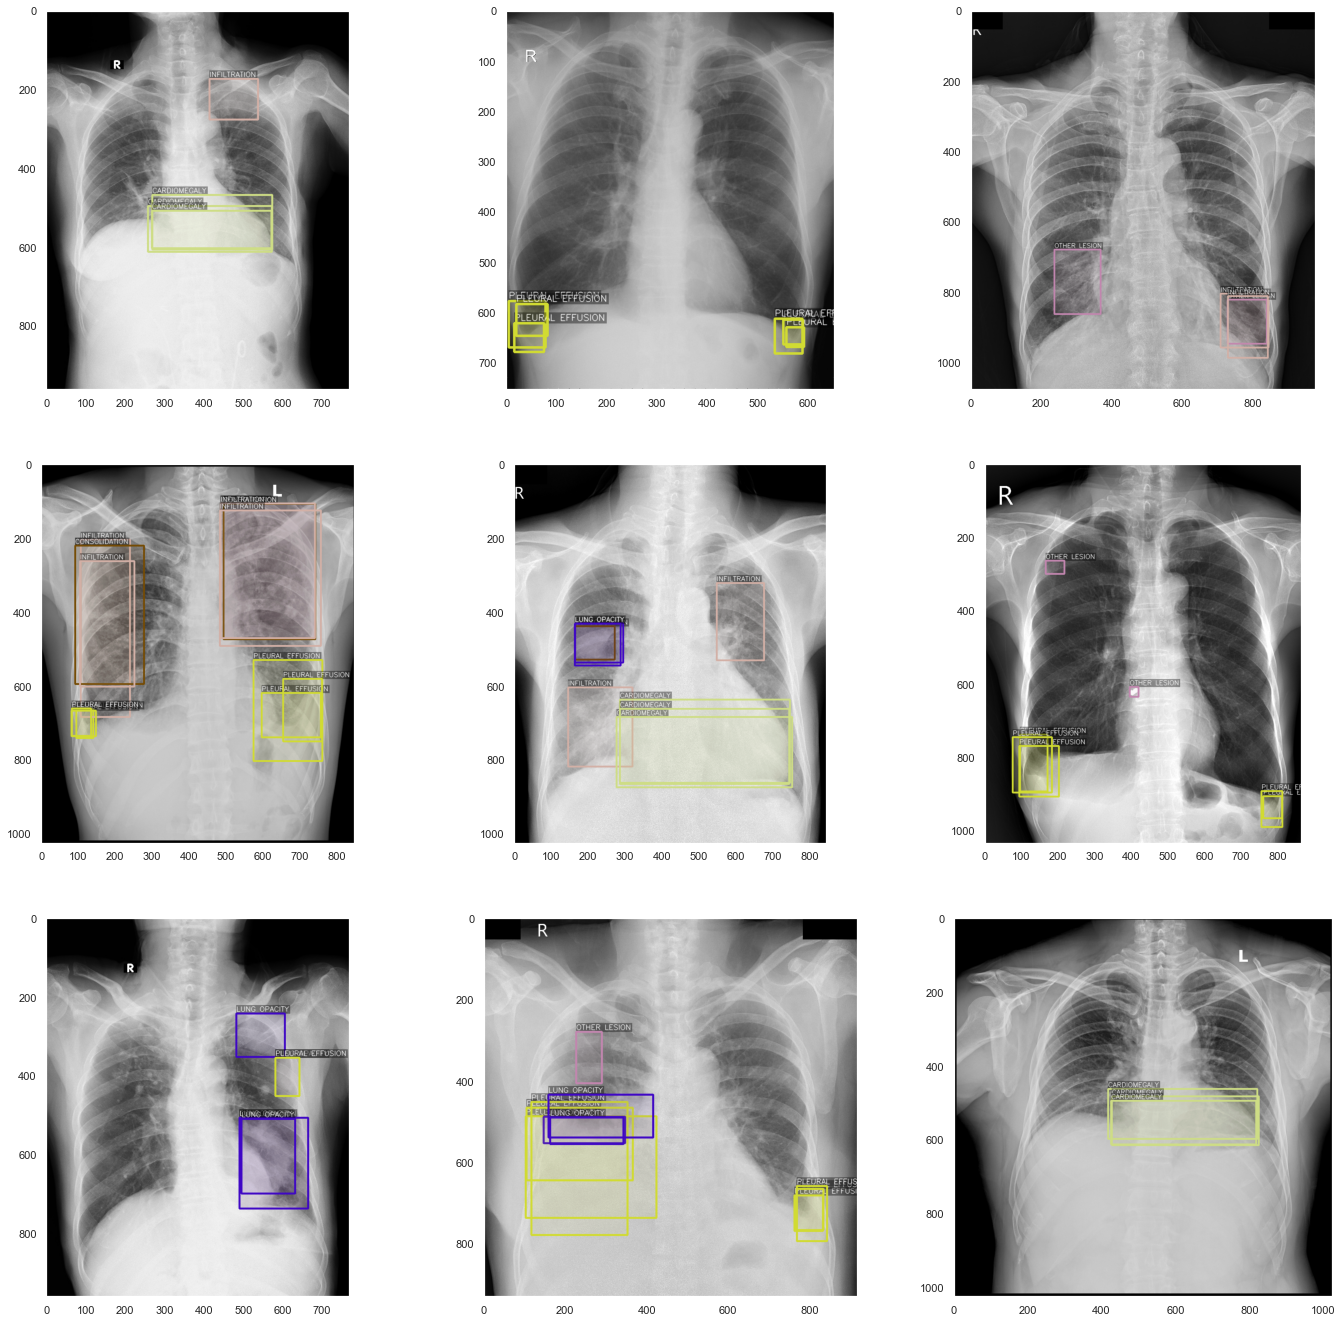

In [39]:
plot_multi_imgs(imgs= viz_images_1, size = 8, cols = 3)

+ Let's explore Other lession

In [40]:
GetKey(9)

'Other lesion'

In [41]:
df_lession = df_finding_train[df_finding_train.class_name == GetKey(9)]
df_lession.head()

image_id    class_name  class_id rad_id  x_min  \
31   c394eadea89e5795c8037280492d116d  Other lesion         9     R9    0.0   
39   8ae85268313b0db2f58d2193aab645c9  Other lesion         9    R10  632.0   
89   5a0fbc7c40ea94bef4c8342d47c05b26  Other lesion         9     R9  236.0   
132  42c049fd05428f7d606e9da4a95a8c3b  Other lesion         9     R9  226.0   
147  53d0c95f346e365f81fb95c5c6a6d027  Other lesion         9    R10  330.0   

     y_min  x_max  y_max                                         image_path  \
31   279.0   91.0  722.0  ..\..\Dataset\train\train\c394eadea89e5795c803...   
39   283.0  800.0  691.0  ..\..\Dataset\train\train\8ae85268313b0db2f58d...   
89   679.0  367.0  862.0  ..\..\Dataset\train\train\5a0fbc7c40ea94bef4c8...   
132  281.0  289.0  407.0  ..\..\Dataset\train\train\42c049fd05428f7d606e...   
147  145.0  383.0  407.0  ..\..\Dataset\train\train\53d0c95f346e365f81fb...   

     image_height  image_width  bbox_area  bbox_height  bbox_width  \
31            960          768    40313.0        443.0        91.0   
39           1024         1024    68544.0        408.0       168.0   
89           1075          978    23973.0        183.0       131.0   
132           929          916     7938.0        126.0        63.0   
147           833          682    13886.0        262.0        53.0   

     bbox_ratio_w/h  xmin_norm  ymin_norm  xmax_norm  ymax_norm  cluster  
31            0.205   0.000000   0.290625   0.118490   0.752083        1  
39            0.412   0.617188   0.276367   0.781250   0.674805        1  
89            0.716   0.241309   0.631628   0.375256   0.801860        1  
132           0.500   0.246725   0.302476   0.315502   0.438105        1  
147           0.202   0.483871   0.174070   0.561584   0.488595        1

In [42]:
df_lession.shape[0]

2203

  0%|          | 0/12 [00:00<?, ?it/s]

c394eadea89e5795c8037280492d116d
boxes_label(id): [9 9 9 9 9 9 9 9 9]
8ae85268313b0db2f58d2193aab645c9
boxes_label(id): [9 9]
5a0fbc7c40ea94bef4c8342d47c05b26
boxes_label(id): [9 9]
42c049fd05428f7d606e9da4a95a8c3b
boxes_label(id): 9
53d0c95f346e365f81fb95c5c6a6d027
boxes_label(id): 9
ba46dcb445340df33566b52d7192ab6e
boxes_label(id): [9 9 9]
c41d4f698ccccbf7068c44c8c14f4e16
boxes_label(id): [9 9 9 9]
aa1ebd488f7f3cab0aa784073b0a9d70
boxes_label(id): 9
872fcda56bcda425012eef3cbf6ebf95
boxes_label(id): [9 9]
aa89a83d50a147e44d6dc72893f01fef
boxes_label(id): [9 9 9]
ea4fd210b0300b23ee63f0b8352390be
boxes_label(id): 9
633a915d9f92edf4edc1c4a85548201f
boxes_label(id): 9


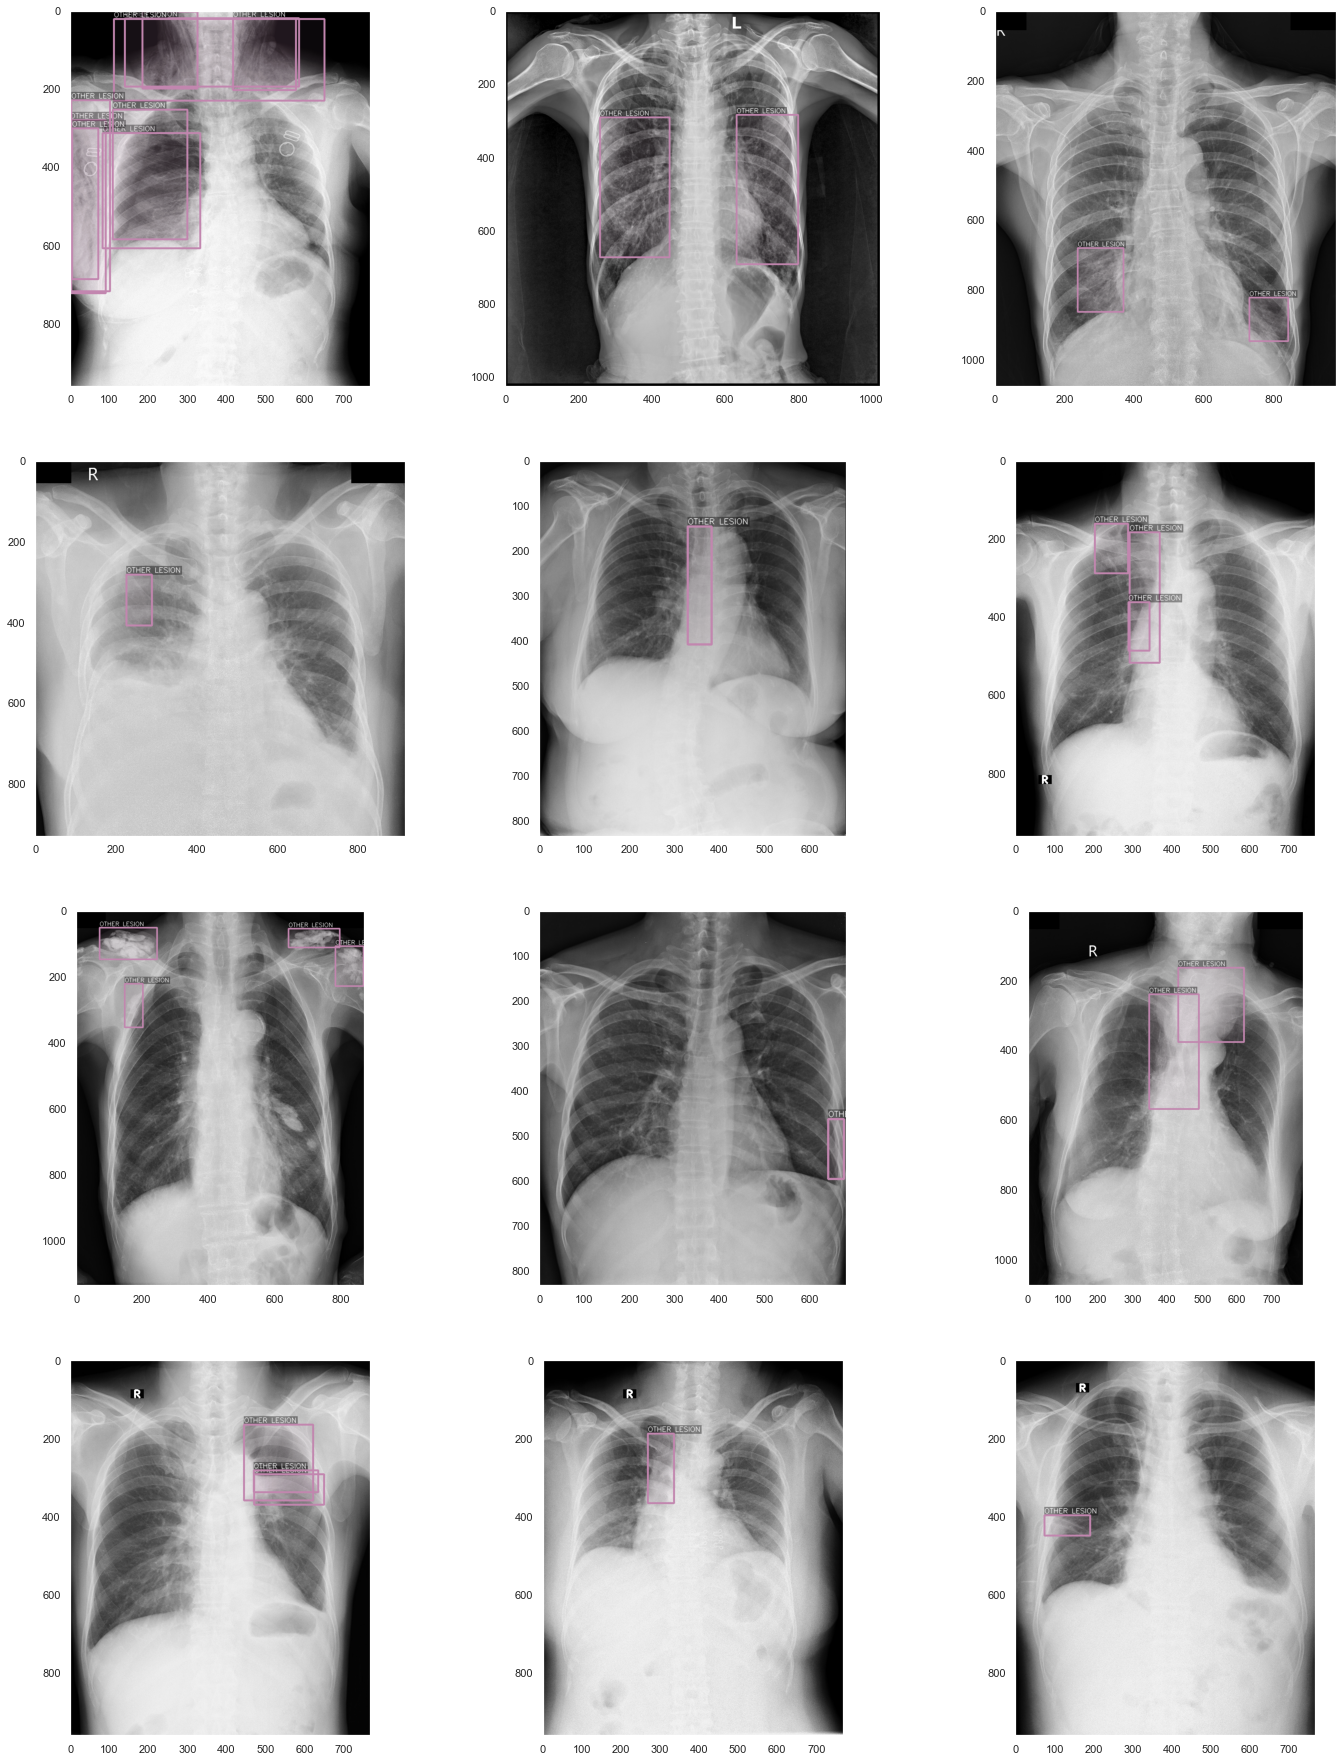

In [48]:
image_path = df_lession.image_path.unique()
thickness =  3
viz_images_lession = []
for img_path in tqdm(image_path[:12], total =len(image_path[:12])):
  img_array = cv2.imread(img_path)
  img_copy = img_array.copy()
  img_id = Path(img_path).stem
  print(img_id)
  boxes_label = df_lession.loc[df_lession["image_id"] == img_id,["class_id"]].values.squeeze()
  boxes_location = df_lession.loc[df_lession["image_id"] == img_id,["x_min", "y_min", "x_max", "y_max"]].values  
  print(f"boxes_label(id): {boxes_label}")
  
  if len(boxes_location) == 1:
    color = label2color[boxes_label]
    img_copy = draw_bbox(img_copy, 
                    list(np.int_(boxes_location.squeeze())), 
                    GetKey(boxes_label), 
                    color, 
                    thickness = thickness)
  else:
    for label_id, box in zip(boxes_label, boxes_location):
      color = label2color[label_id]
      img_copy = draw_bbox(img_copy, 
                      list(np.int_(box)), 
                      GetKey(label_id), 
                      color, 
                      thickness = thickness)
  viz_images_lession.append(img_copy)
plot_multi_imgs(imgs= viz_images_lession, size = 8, cols = 3)

### 1.3 Cluster 0

In [44]:
imgs_path_0 = df_finding_train_c_0.image_path.unique()

In [45]:
df_finding_train_c_0.class_name.unique()

array(['Aortic enlargement', 'Pleural thickening', 'Nodule/Mass',
       'Pulmonary fibrosis', 'Calcification'], dtype=object)

  0%|          | 0/9 [00:00<?, ?it/s]

051132a778e61a86eb147c7c6f564dfe
boxes_label(id): [ 0  0 11  0]
1c32170b4af4ce1a3030eb8167753b06
boxes_label(id): [11 13 11 13 13 13 11 13 13]
47ed17dcb2cbeec15182ed335a8b5a9e
boxes_label(id): [8 8 8]
d3637a1935a905b3c326af31389cb846
boxes_label(id): [ 0 13 11  8 13 13 11 13  8  8 13]
afb6230703512afc370f236e8fe98806
boxes_label(id): [13  0 13 13  0 13  0]
18a61a07e6f5f13ebfee57fa36cd8b6f
boxes_label(id): [13  2 13 11  2  8 11 13 11]
321c111713c3ee5385db0effb54ff568
boxes_label(id): [ 0  8  2 13  8]
5da264775732004f1b724b660138854a
boxes_label(id): [0 0 0]
fb8e11c6b2886b2d41b379e0598669b9
boxes_label(id): [ 0 11  8 11 11  8  0  8 13 11 11]


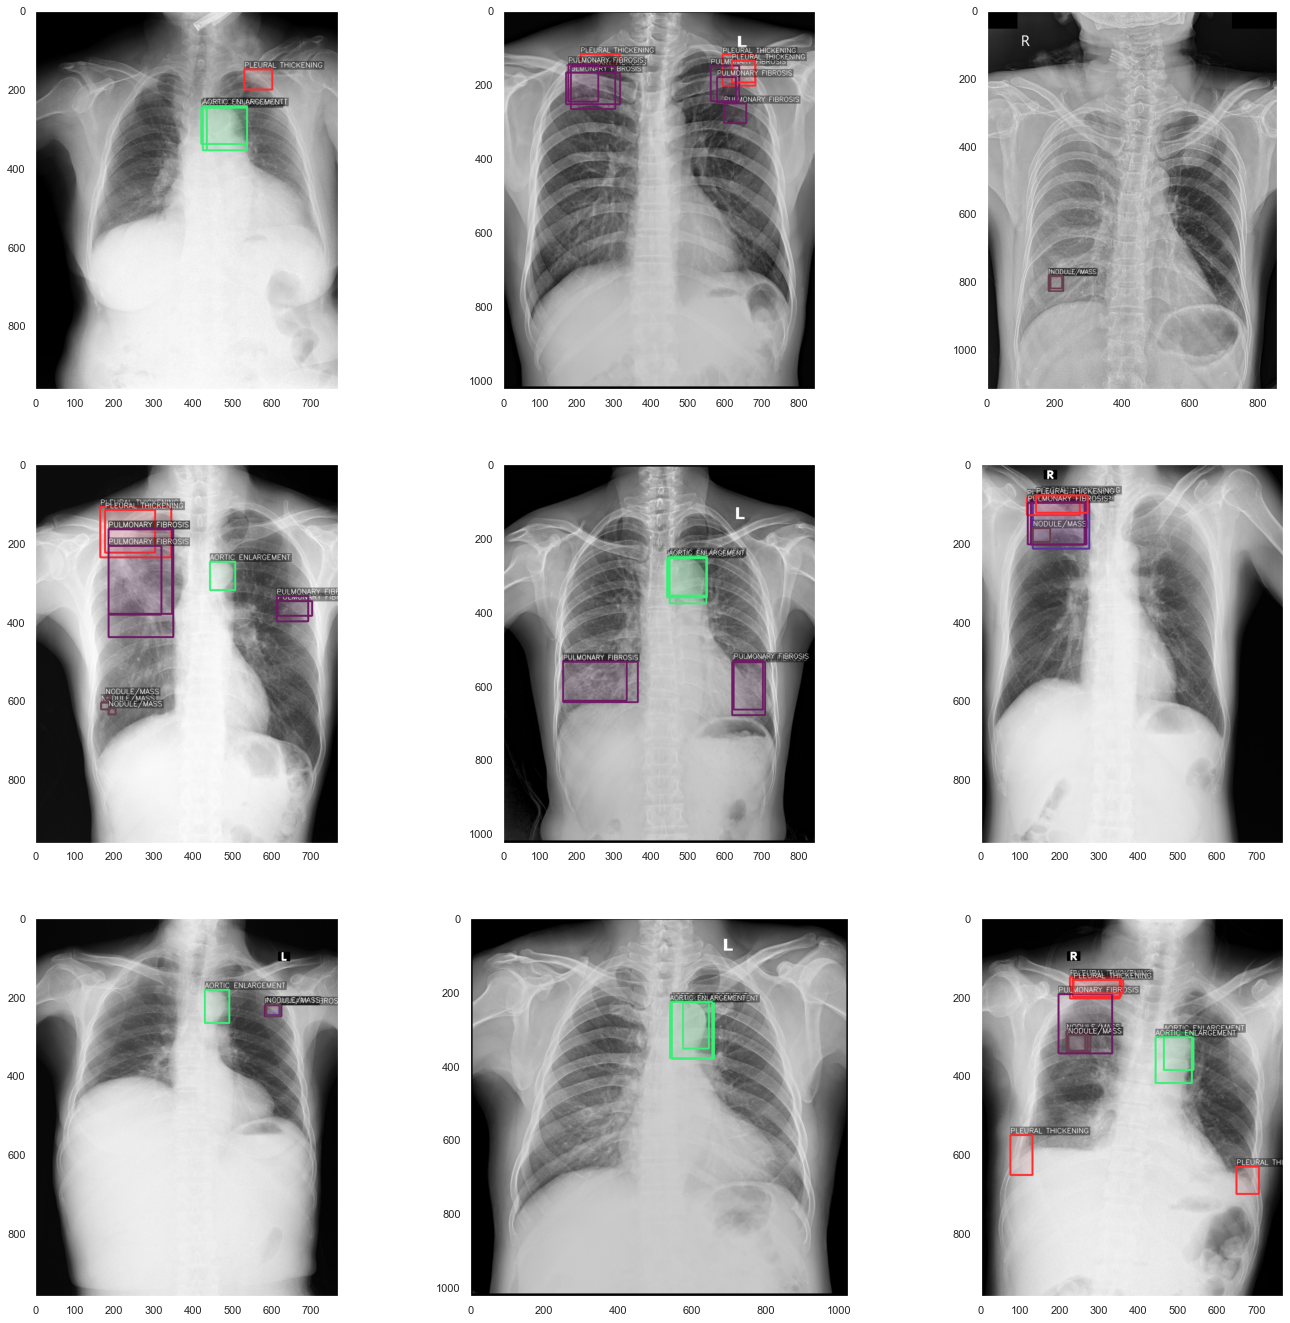

In [49]:
thickness =  3
viz_images_0 = []
for img_path in tqdm(imgs_path_0[:9], total =len(imgs_path_0[:9])):
  img_array = cv2.imread(img_path)
  img_copy = img_array.copy()
  img_id = Path(img_path).stem
  print(img_id)
  boxes_label = df_finding_train_c_0.loc[df_finding_train_c_0["image_id"] == img_id,["class_id"]].values.squeeze()
  boxes_location = df_finding_train_c_0.loc[df_finding_train_c_0["image_id"] == img_id,["x_min", "y_min", "x_max", "y_max"]].values  
  print(f"boxes_label(id): {boxes_label}")
  
  if len(boxes_location) == 1:
    color = label2color[boxes_label]
    img_copy = draw_bbox(img_copy, 
                    list(np.int_(boxes_location.squeeze())), 
                    GetKey(boxes_label), 
                    color, 
                    thickness = thickness)
  else:
    for label_id, box in zip(boxes_label, boxes_location):
      color = label2color[label_id]
      img_copy = draw_bbox(img_copy, 
                      list(np.int_(box)), 
                      GetKey(label_id), 
                      color, 
                      thickness = thickness)
  viz_images_0.append(img_copy)
plot_multi_imgs(imgs= viz_images_0, size = 8, cols = 3)